# 模型选择、欠拟合和过拟合

通过多项式拟合来探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

查看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.5491],
         [ 0.6516]]),
 tensor([[ 1.0000e+00, -5.4909e-01,  1.5075e-01, -2.7592e-02,  3.7876e-03,
          -4.1595e-04,  3.8066e-05, -2.9860e-06,  2.0495e-07, -1.2504e-08,
           6.8657e-10, -3.4272e-11,  1.5682e-12, -6.6238e-14,  2.5979e-15,
          -9.5099e-17,  3.2636e-18, -1.0541e-19,  3.2156e-21, -9.2931e-23],
         [ 1.0000e+00,  6.5162e-01,  2.1230e-01,  4.6113e-02,  7.5120e-03,
           9.7898e-04,  1.0632e-04,  9.8971e-06,  8.0614e-07,  5.8366e-08,
           3.8032e-09,  2.2529e-10,  1.2234e-11,  6.1321e-13,  2.8541e-14,
           1.2399e-15,  5.0494e-17,  1.9355e-18,  7.0065e-20,  2.4029e-21]]),
 tensor([3.5591, 5.3161]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正常)

weight: [[ 4.993906   1.2246284 -3.3686247  5.452925 ]]


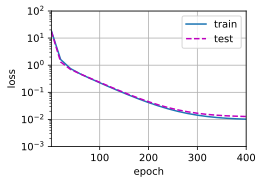

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.5880713 3.1436489]]


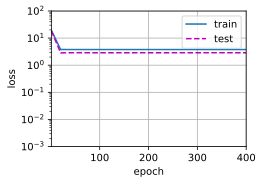

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 5.0002198e+00  1.2467500e+00 -3.3591731e+00  5.1664433e+00
  -2.0427971e-01  1.3719110e+00  1.4664979e-01  2.0325291e-01
   2.2558092e-01  9.9882804e-02 -1.2002296e-01  6.2667161e-02
   1.2657876e-01  5.9042003e-02  1.0403855e-01  1.8731797e-01
  -4.1237131e-02 -1.6897091e-01 -9.8454226e-03 -4.6975882e-04]]


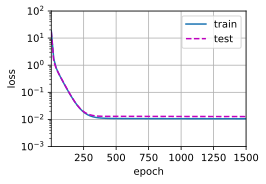

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)